Import Libraries

In [4]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import seaborn as sns
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Conv2D, TimeDistributed, Flatten, GRU, Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

Set Numpy, Python, and TF seeds

In [ ]:
model_input_size = (224,224,3)
seed_constant = 7
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

batch_size = 8 # Change this shit pag sasabog na yung GPU

Visualize Data

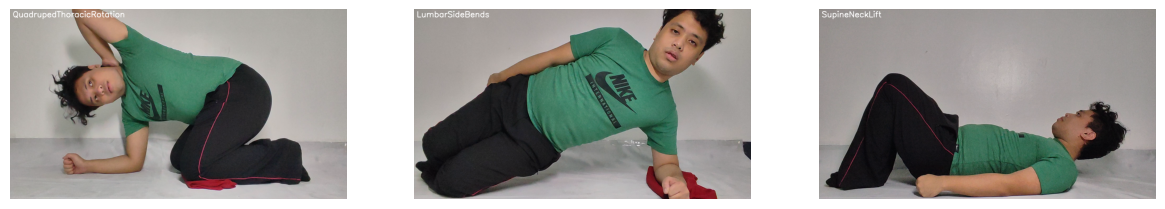

In [8]:
plt.figure(figsize = (20,20))

all_class_names = os.listdir('raw')

random_range = random.sample(range(len(all_class_names)), 3)

for counter, random_index in enumerate(random_range, 1):
    selected_class_name = all_class_names[random_index]

    video_files_names_list = os.listdir(f'raw/{selected_class_name}') 
    selected_video_file_name =  random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'raw/{selected_class_name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)

    plt.subplot(5,4, counter);plt.imshow(rgb_frame);plt.axis('off')


PreProcess the Dataset

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH =  64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = r"D:\MAPUA\CNN-GRU_exp\UCF50"

CLASSES_LIST = ["BenchPress", "CleanAndJerk", "JumpingJack", "Lunges", "PushUps", "Taichi"]